****A Hybrid LSTM-PPO Framework for High-Accuracy Options Trading Based on Technical Setups in the Indian Market****


**Build a smart AI system that takes any technical strategy (like gap-up, trap candle, impulsive), and uses LSTM to classify the signal’s strength and PPO/DQN to decide whether to trade CE, PE, or skip — all based on PnL reward and market context.**

Install Required Dependancies

In [15]:
!pip3 install smartapi-python --upgrade stable-baselines3
!pip3 install pandas_ta


!pip3 install stable-baselines3
!pip3 install shimmy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [16]:
from SmartApi import SmartConnect
import pyotp
import http.client
import json
from datetime import datetime, timedelta
import pandas as pd
import socket
import requests
import uuid
from ta.trend import EMAIndicator, MACD, ADXIndicator
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.volatility import BollingerBands
from sklearn.preprocessing import MinMaxScaler

In [17]:
def Login_To_Angleone():
    api_key = "WUCyfVgK" # Using the first API Key
    smartAPI = SmartConnect(api_key)
    try:

        totp = pyotp.TOTP("2AMWG2Z2FZ3ZOFBJATC7EFDWFY").now()
        data = smartAPI.generateSession("N274681", "6499", totp)
        if not data['status']:
            return None

        jwtToken = data['data']['jwtToken']
        refreshToken = data['data']['refreshToken']
        feedToken = data['data']['feedToken']
        return jwtToken, refreshToken, feedToken, smartAPI
    except Exception as e:
        print(f"Error: {e}")
        return None

In [18]:
jwtToken, refreshToken, feedToken, smartAPI = Login_To_Angleone()

[I 250420 00:55:55 smartConnect:124] in pool


In [19]:
def Get_IP_Info():
    s = socket.socket(socket.AF_INET,  socket.SOCK_DGRAM)

    local_IP =  "127.0.0.1"
    Public_IP = requests.get("https://api.ipify.org").text

    try:
        s.connect(("10.254.254.254",1)) # We use 10.254.254.254 to trick system to get local IP
        local_IP = s.getsockname()[0]
    finally:
        s.close()
    return local_IP, Public_IP,':'.join(['{:02x}'.format((uuid.getnode() >> elements) & 0xff) for elements in range(0, 2*6, 2)][::-1])

In [20]:
from time import sleep


def fetch_5_years_5min_candle(authToken, index):
    

    # Get stock token
    Stock_Token = "99926000" # For Nifty

    conn = http.client.HTTPSConnection("apiconnect.angelbroking.com")
    local_IP, public_IP, mac_address = Get_IP_Info()
    apikey = "WUCyfVgK"

    # Define time range
    end_date = datetime.now().replace(second=0, microsecond=0)
    start_date = end_date - timedelta(days=365 * 5)  # 5 years ago

    all_candles = []

    while start_date < end_date:
        batch_end = min(start_date + timedelta(days=30), end_date)

        payload = json.dumps({
            "exchange": "NSE",
            "symboltoken": Stock_Token,
            "interval": "FIVE_MINUTE",
            "fromdate": start_date.strftime("%Y-%m-%d %H:%M"),
            "todate": batch_end.strftime("%Y-%m-%d %H:%M")
        })

        headers = {
            'X-PrivateKey': apikey,
            'Authorization': authToken,
            'X-SourceID': 'WEB',
            'X-ClientLocalIP': local_IP,
            'X-ClientPublicIP': public_IP,
            'X-MACAddress': mac_address,
            'X-UserType': 'USER',
            'Accept': 'application/json',
            'Content-Type': 'application/json'
        }

        try:
            conn.request("POST", "/rest/secure/angelbroking/historical/v1/getCandleData", payload, headers)
            res = conn.getresponse()
            data = res.read().decode("utf-8")
            response_json = json.loads(data)
        except Exception as e:
            print(f"Request failed from {start_date} to {batch_end}: {e}")
            break

        if 'data' in response_json and response_json['data']:
            all_candles.extend(response_json['data'])
            print(f"✅ Fetched: {start_date.strftime('%Y-%m-%d')} to {batch_end.strftime('%Y-%m-%d')} - Candles: {len(response_json['data'])}")
        else:
            print(f"⚠️ No data for {start_date.strftime('%Y-%m-%d')} to {batch_end.strftime('%Y-%m-%d')}")

        # Move to next batch
        start_date = batch_end
        sleep(1.2)  # avoid rate limiting (optional, adjust as needed)

    conn.close()

    if not all_candles:
        return None

    # Convert to DataFrame
    df = pd.DataFrame(all_candles, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    
    return df

In [21]:
df = fetch_5_years_5min_candle(jwtToken, "NIFTY")

✅ Fetched: 2020-04-21 to 2020-05-21 - Candles: 1575
✅ Fetched: 2020-05-21 to 2020-06-20 - Candles: 1575
✅ Fetched: 2020-06-20 to 2020-07-20 - Candles: 1500
✅ Fetched: 2020-07-20 to 2020-08-19 - Candles: 1650
✅ Fetched: 2020-08-19 to 2020-09-18 - Candles: 1650
✅ Fetched: 2020-09-18 to 2020-10-18 - Candles: 1500
✅ Fetched: 2020-10-18 to 2020-11-17 - Candles: 1514
✅ Fetched: 2020-11-17 to 2020-12-17 - Candles: 1575
✅ Fetched: 2020-12-17 to 2021-01-16 - Candles: 1575
✅ Fetched: 2021-01-16 to 2021-02-15 - Candles: 1425
✅ Fetched: 2021-02-15 to 2021-03-17 - Candles: 1526
✅ Fetched: 2021-03-17 to 2021-04-16 - Candles: 1425
✅ Fetched: 2021-04-16 to 2021-05-16 - Candles: 1425
✅ Fetched: 2021-05-16 to 2021-06-15 - Candles: 1575
✅ Fetched: 2021-06-15 to 2021-07-15 - Candles: 1650
✅ Fetched: 2021-07-15 to 2021-08-14 - Candles: 1575
✅ Fetched: 2021-08-14 to 2021-09-13 - Candles: 1350
✅ Fetched: 2021-09-13 to 2021-10-13 - Candles: 1650
✅ Fetched: 2021-10-13 to 2021-11-12 - Candles: 1438
✅ Fetched: 2

In [22]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.index = df.index.tz_localize(None)
df.head(-1)

,open,high,low,close,volume
timestamp,,,,,
2020-04-21 09:15:00,9016.95,9044.40,8992.10,9031.75,0.0
2020-04-21 09:20:00,9033.45,9033.45,8984.95,8993.15,0.0
2020-04-21 09:25:00,8993.10,9003.30,8969.70,8987.35,0.0
2020-04-21 09:30:00,8987.90,9008.10,8973.60,9005.15,0.0
2020-04-21 09:35:00,9004.95,9026.55,9001.40,9018.60,0.0
...,...,...,...,...,...
2025-04-17 15:00:00,23857.15,23872.35,23843.85,23855.80,0.0
2025-04-17 15:05:00,23855.25,23859.55,23846.65,23853.15,0.0
2025-04-17 15:10:00,23852.50,23855.75,23844.90,23847.00,0.0


In [23]:
import pandas_ta as ta

def add_all_indicators(df):
    # Trend Indicators
    df['ema_20'] = ta.ema(df['close'], length=20)
    df['ema_50'] = ta.ema(df['close'], length=50)
    df['ema_200'] = ta.ema(df['close'], length=200)
    df['sma_20'] = ta.sma(df['close'], length=20)
    df['sma_50'] = ta.sma(df['close'], length=50)

    # Momentum Indicators
    df['rsi_14'] = ta.rsi(df['close'], length=14)
    df['macd'] = ta.macd(df['close'])['MACD_12_26_9']
    df['macd_signal'] = ta.macd(df['close'])['MACDs_12_26_9']
    df['stoch_k'] = ta.stoch(df['high'], df['low'], df['close'])['STOCHk_14_3_3']
    df['stoch_d'] = ta.stoch(df['high'], df['low'], df['close'])['STOCHd_14_3_3']
    df['cci'] = ta.cci(df['high'], df['low'], df['close'], length=20)

    # Volatility Indicators
    bb = ta.bbands(df['close'], length=20)
    df['bb_upper'] = bb['BBU_20_2.0']
    df['bb_middle'] = bb['BBM_20_2.0']
    df['bb_lower'] = bb['BBL_20_2.0']
    df['atr'] = ta.atr(df['high'], df['low'], df['close'], length=14)

    # Volume-Based Indicators

    # Trend Strength
    df['adx'] = ta.adx(df['high'], df['low'], df['close'], length=14)['ADX_14']
    
    return df


In [24]:
df = add_all_indicators(df)

In [25]:
df.head(-1)

,open,high,low,close,volume,ema_20,ema_50,ema_200,sma_20,sma_50,...,macd,macd_signal,stoch_k,stoch_d,cci,bb_upper,bb_middle,bb_lower,atr,adx
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-04-21 09:15:00,9016.95,9044.40,8992.10,9031.75,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-21 09:20:00,9033.45,9033.45,8984.95,8993.15,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-21 09:25:00,8993.10,9003.30,8969.70,8987.35,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-21 09:30:00,8987.90,9008.10,8973.60,9005.15,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04-21 09:35:00,9004.95,9026.55,9001.40,9018.60,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17 15:00:00,23857.15,23872.35,23843.85,23855.80,0.0,23825.285378,23722.276874,23424.196601,23836.5575,23707.537,...,41.270764,49.191923,82.361494,84.161430,70.176823,23887.945439,23836.5575,23785.169561,25.158790,40.905924
2025-04-17 15:05:00,23855.25,23859.55,23846.65,23853.15,0.0,23827.939152,23727.409153,23428.464794,23840.4500,23716.467,...,38.752961,47.104131,81.606984,82.857880,52.691825,23883.862901,23840.4500,23797.037099,24.283163,39.534734
2025-04-17 15:10:00,23852.50,23855.75,23844.90,23847.00,0.0,23829.754471,23732.098990,23432.629323,23843.9750,23725.859,...,35.848097,44.852924,76.999812,80.322763,32.028896,23876.000576,23843.9750,23811.949424,23.323651,38.152491


In [26]:
df.dropna(inplace=True)


In [27]:
df.head(-1)

,open,high,low,close,volume,ema_20,ema_50,ema_200,sma_20,sma_50,...,macd,macd_signal,stoch_k,stoch_d,cci,bb_upper,bb_middle,bb_lower,atr,adx
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-04-23 13:20:00,9272.50,9274.05,9250.80,9264.40,0.0,9294.848896,9270.176056,9101.399250,9304.6275,9281.649,...,0.884390,8.285417,20.703653,24.608992,-249.022585,9334.535266,9304.6275,9274.719734,18.012051,28.722527
2020-04-23 13:25:00,9264.85,9283.70,9257.50,9271.70,0.0,9292.644239,9270.235819,9103.093785,9303.0750,9282.660,...,-0.901778,6.447978,19.343399,21.524614,-162.204088,9336.255906,9303.0750,9269.894094,18.596905,28.209787
2020-04-23 13:30:00,9272.90,9277.50,9256.80,9258.00,0.0,9289.344788,9269.755983,9104.635140,9300.4775,9283.422,...,-3.383799,4.481623,18.663354,19.570135,-157.916603,9338.829586,9300.4775,9262.125414,18.747126,27.771524
2020-04-23 13:35:00,9257.50,9258.30,9237.30,9249.90,0.0,9285.588142,9268.977317,9106.080562,9297.2050,9283.923,...,-5.935993,2.398099,17.560385,18.522379,-177.838026,9340.741466,9297.2050,9253.668534,18.908045,28.302427
2020-04-23 13:40:00,9249.85,9267.50,9245.40,9266.00,0.0,9283.722604,9268.860559,9107.671800,9294.6375,9284.519,...,-6.583599,0.601760,19.422974,18.548904,-117.315251,9339.164367,9294.6375,9250.110633,19.136042,28.033836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17 15:00:00,23857.15,23872.35,23843.85,23855.80,0.0,23825.285378,23722.276874,23424.196601,23836.5575,23707.537,...,41.270764,49.191923,82.361494,84.161430,70.176823,23887.945439,23836.5575,23785.169561,25.158790,40.905924
2025-04-17 15:05:00,23855.25,23859.55,23846.65,23853.15,0.0,23827.939152,23727.409153,23428.464794,23840.4500,23716.467,...,38.752961,47.104131,81.606984,82.857880,52.691825,23883.862901,23840.4500,23797.037099,24.283163,39.534734
2025-04-17 15:10:00,23852.50,23855.75,23844.90,23847.00,0.0,23829.754471,23732.098990,23432.629323,23843.9750,23725.859,...,35.848097,44.852924,76.999812,80.322763,32.028896,23876.000576,23843.9750,23811.949424,23.323651,38.152491


In [28]:
def label_trades_first_hit(df, target_move=80, lookahead=5):
    """
    Labels each candle in the dataframe based on whether the price
    moves up or down by a target amount within a lookahead window.
    
    Parameters:
        df (pd.DataFrame): DataFrame with a 'close' column
        target_move (float): The number of points price must move to trigger a label
        lookahead (int): Number of future candles to look ahead

    Returns:
        df (pd.DataFrame): Same dataframe with an added 'label' column
                          1 = Buy CE, 2 = Buy PE, 0 = No Trade
    """
    labels = []
    close_prices = df['close'].values

    for i in range(len(df) - lookahead):
        entry_price = close_prices[i]
        label = 0  # Default: No Trade

        for j in range(1, lookahead + 1):
            future_price = close_prices[i + j]

            # Check for Buy CE
            if future_price - entry_price >= target_move:
                label = 1
                break

            # Check for Buy PE
            elif entry_price - future_price >= target_move:
                label = 2
                break

        labels.append(label)

    # Pad the end with 0s (no label for incomplete future data)
    labels += [0] * lookahead
    df['label'] = labels

    return df


In [29]:
df = label_trades_first_hit(df, target_move=80, lookahead=5)


In [30]:
df.head(-1)

,open,high,low,close,volume,ema_20,ema_50,ema_200,sma_20,sma_50,...,macd_signal,stoch_k,stoch_d,cci,bb_upper,bb_middle,bb_lower,atr,adx,label
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-04-23 13:20:00,9272.50,9274.05,9250.80,9264.40,0.0,9294.848896,9270.176056,9101.399250,9304.6275,9281.649,...,8.285417,20.703653,24.608992,-249.022585,9334.535266,9304.6275,9274.719734,18.012051,28.722527,0
2020-04-23 13:25:00,9264.85,9283.70,9257.50,9271.70,0.0,9292.644239,9270.235819,9103.093785,9303.0750,9282.660,...,6.447978,19.343399,21.524614,-162.204088,9336.255906,9303.0750,9269.894094,18.596905,28.209787,0
2020-04-23 13:30:00,9272.90,9277.50,9256.80,9258.00,0.0,9289.344788,9269.755983,9104.635140,9300.4775,9283.422,...,4.481623,18.663354,19.570135,-157.916603,9338.829586,9300.4775,9262.125414,18.747126,27.771524,0
2020-04-23 13:35:00,9257.50,9258.30,9237.30,9249.90,0.0,9285.588142,9268.977317,9106.080562,9297.2050,9283.923,...,2.398099,17.560385,18.522379,-177.838026,9340.741466,9297.2050,9253.668534,18.908045,28.302427,0
2020-04-23 13:40:00,9249.85,9267.50,9245.40,9266.00,0.0,9283.722604,9268.860559,9107.671800,9294.6375,9284.519,...,0.601760,19.422974,18.548904,-117.315251,9339.164367,9294.6375,9250.110633,19.136042,28.033836,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-17 15:00:00,23857.15,23872.35,23843.85,23855.80,0.0,23825.285378,23722.276874,23424.196601,23836.5575,23707.537,...,49.191923,82.361494,84.161430,70.176823,23887.945439,23836.5575,23785.169561,25.158790,40.905924,0
2025-04-17 15:05:00,23855.25,23859.55,23846.65,23853.15,0.0,23827.939152,23727.409153,23428.464794,23840.4500,23716.467,...,47.104131,81.606984,82.857880,52.691825,23883.862901,23840.4500,23797.037099,24.283163,39.534734,0
2025-04-17 15:10:00,23852.50,23855.75,23844.90,23847.00,0.0,23829.754471,23732.098990,23432.629323,23843.9750,23725.859,...,44.852924,76.999812,80.322763,32.028896,23876.000576,23843.9750,23811.949424,23.323651,38.152491,0


No Trade (Label 0): 87011
Buy CE (Label 1): 2825
Buy PE (Label 2): 2649


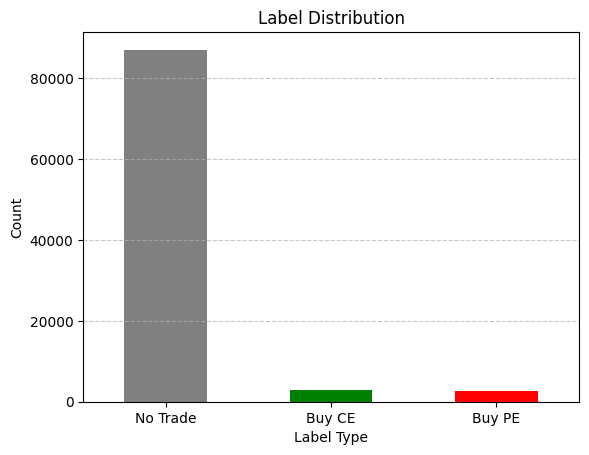

In [31]:
label_counts = df['label'].value_counts().sort_index()

# Print nicely
label_map = {0: 'No Trade', 1: 'Buy CE', 2: 'Buy PE'}
for label, count in label_counts.items():
    print(f"{label_map[label]} (Label {label}): {count}")

import matplotlib.pyplot as plt

label_counts.rename(index=label_map).plot(kind='bar', color=['gray', 'green', 'red'])
plt.title('Label Distribution')
plt.ylabel('Count')
plt.xlabel('Label Type')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


🔁 Phase-by-Phase LSTM Workflow in Jupyter

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import BorderlineSMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, LSTM, Dense, Dropout, BatchNormalization,
                                     Bidirectional, Lambda, Flatten, Activation,
                                     RepeatVector, Permute, Multiply)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K


In [33]:
features = [
    'close', 'open', 'high', 'low',
    'ema_200', 'rsi_14', 'macd', 'adx',
    'bb_upper', 'bb_lower', 'stoch_k', 'stoch_d'
]

scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])


In [34]:
SEQ_LEN = 60
X, y = [], []

for i in range(SEQ_LEN, len(df)):
    X.append(df[features].iloc[i-SEQ_LEN:i].values)
    y.append(df['label'].iloc[i])  # ⬅️ using 'label' now

X = np.array(X)
y = np.array(y)


In [35]:
X_flat = X.reshape(X.shape[0], -1)
smote = BorderlineSMOTE(kind='borderline-2', random_state=42)
X_res, y_res = smote.fit_resample(X_flat, y)
X_res = X_res.reshape(-1, SEQ_LEN, len(features))


/Users/nil/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [37]:
# ✅ Attention Block (unchanged)
def attention_block_with_weights(inputs):
    attention_scores = Dense(1, activation='tanh')(inputs)
    attention_scores = Flatten()(attention_scores)
    attention_weights = Activation('softmax', name='attention_weights')(attention_scores)
    attention_weights = RepeatVector(inputs.shape[-1])(attention_weights)
    attention_weights = Permute([2, 1])(attention_weights)
    context_vector = Multiply()([inputs, attention_weights])
    return context_vector, attention_weights



In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

# 🔁 Your custom attention block must be defined already
# Example placeholder:
# def attention_block_with_weights(inputs): ...

# ✅ Replace this Lambda with a named function
def temporal_sum(x):
    return K.sum(x, axis=1)

# 📥 Input shape
input_shape = (X_res.shape[1], X_res.shape[2])
inp = Input(shape=input_shape)

# 🧠 LSTM Layers
x = Bidirectional(LSTM(128, return_sequences=True))(inp)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# 🧲 Attention layer (with visualization support)
x, att_weights = attention_block_with_weights(x)

# ✅ Use named Lambda layer instead of inline lambda
x = Lambda(temporal_sum)(x)

# 🧮 Dense layers
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(3, activation='softmax')(x)

# 🏗️ Model
model = Model(inputs=inp, outputs=output)

# ⚙️ Compile
model.compile(optimizer=Adam(0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 📋 Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 60, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 60, 256)   │    144,384 │ input_layer_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 256)   │      1,024 │ bidirectional_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 60, 256)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 60, 128)   │    164,352 │ dropout_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 128)   │        512 │ bidirectional_3[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 60, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 60, 1)     │        129 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 60)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_weights   │ (None, 60)        │          0 │ flatten[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 128, 60)   │          0 │ attention_weight… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 60, 128)   │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 60, 128)   │          0 │ dropout_3[0][0],  │
│                     │                   │            │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        195 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 318,852 (1.22 MB)

 Trainable params: 318,084 (1.21 MB)

 Non-trainable params: 768 (3.00 KB)

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_res), y=y_res)
class_weights = dict(enumerate(class_weights))


In [36]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint("best_lstm_attention_model.keras", monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)


Epoch 1/60
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4286 - loss: 1.0962
Epoch 1: val_loss improved from inf to 0.87332, saving model to best_lstm_attention_model.keras
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 520s 159ms/step - accuracy: 0.4287 - loss: 1.0962 - val_accuracy: 0.5892 - val_loss: 0.8733 - learning_rate: 5.0000e-04
Epoch 2/60
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6769 - loss: 0.7290
Epoch 2: val_loss improved from 0.87332 to 0.53959, saving model to best_lstm_attention_model.keras
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 510s 156ms/step - accuracy: 0.6769 - loss: 0.7290 - val_accuracy: 0.7800 - val_loss: 0.5396 - learning_rate: 5.0000e-04
Epoch 3/60
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8012 - loss: 0.4992
Epoch 3: val_loss improved from 0.53959 to 0.40349, saving model to best_lstm_attention_model.keras
3263/3263 ━━━━━━━━━━━━━━━━━━━━ 531s 163ms/step - accuracy: 0.8012 - loss: 0.4992 - val_accuracy: 0.8482 - val_loss: 0.4035 - learnin

In [37]:
att_model = Model(inputs=model.input, outputs=att_weights)
att_model.save("attention_visualizer_model.keras")


1632/1632 ━━━━━━━━━━━━━━━━━━━━ 62s 38ms/step
Classification Report:
              precision    recall  f1-score   support

    No Trade       0.99      0.94      0.96     17337
      Buy CE       0.97      0.99      0.98     17358
      Buy PE       0.97      0.99      0.98     17498

    accuracy                           0.98     52193
   macro avg       0.98      0.98      0.98     52193
weighted avg       0.98      0.98      0.98     52193



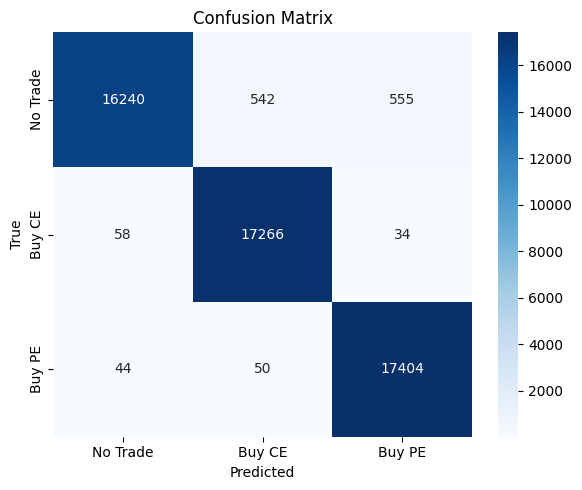

In [38]:
# Predict on validation set
y_pred_probs = model.predict(X_val)  # ✅ Only one output
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=["No Trade", "Buy CE", "Buy PE"]))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Trade", "Buy CE", "Buy PE"],
            yticklabels=["No Trade", "Buy CE", "Buy PE"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


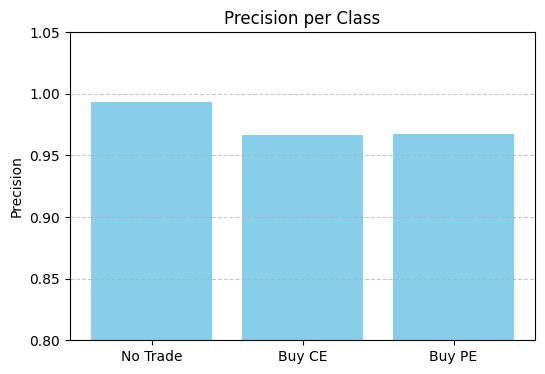

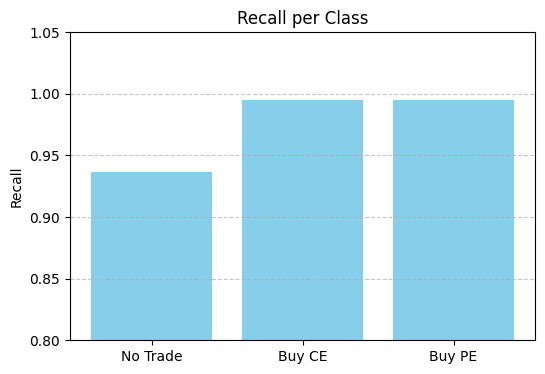

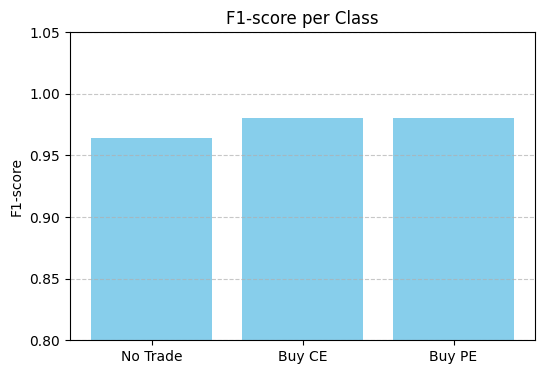

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

report = classification_report(y_val, y_pred, target_names=["No Trade", "Buy CE", "Buy PE"], output_dict=True)

metrics = ["precision", "recall", "f1-score"]
classes = ["No Trade", "Buy CE", "Buy PE"]

for metric in metrics:
    plt.figure(figsize=(6,4))
    values = [report[c][metric] for c in classes]
    plt.bar(classes, values, color="skyblue")
    plt.ylim(0.8, 1.05)
    plt.title(f"{metric.capitalize()} per Class")
    plt.ylabel(metric.capitalize())
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()


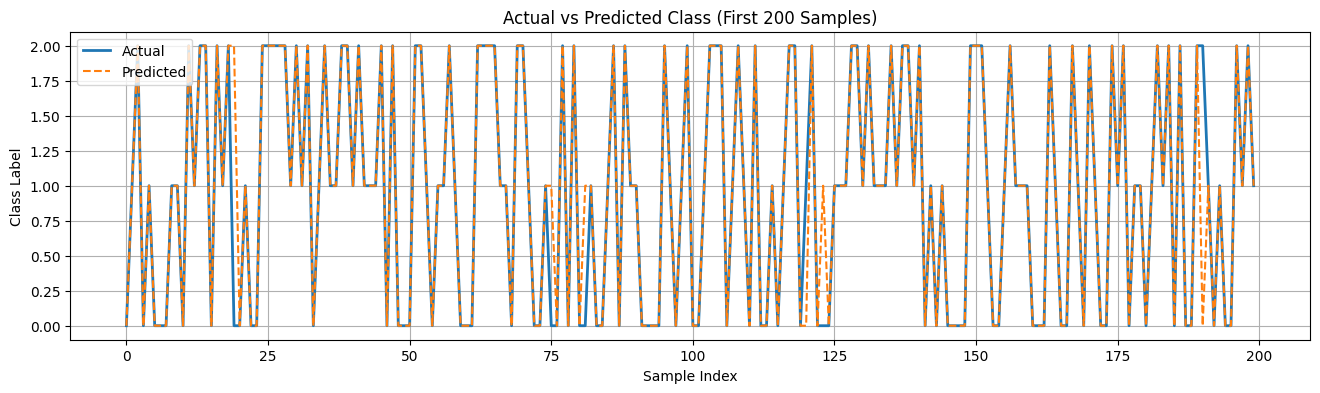

In [40]:
plt.figure(figsize=(16,4))
plt.plot(y_val[:200], label="Actual", linewidth=2)
plt.plot(y_pred[:200], label="Predicted", linestyle='--')
plt.title("Actual vs Predicted Class (First 200 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Class Label")
plt.legend()
plt.grid(True)
plt.show()


In [47]:
df.to_csv("ppo_ready_data.csv", index=False)

In [46]:
 # Step 1: Build X_res and track row indexes
SEQ_LEN = 60
X_res = []
aligned_rows = []

for i in range(SEQ_LEN, len(df)):
    seq = df.iloc[i-SEQ_LEN:i].values
    X_res.append(seq)
    aligned_rows.append(i)

X_res = np.array(X_res)



In [31]:
df_val = df.iloc[-len(X_val):].copy()
df_val['predicted_label'] = y_pred  # Optional: attach predictions if needed

df_val.to_csv("ppo_validation_data.csv", index=False)

In [33]:
np.save("y_pred_probs.npy", y_pred_probs)

HERE START THE RESUlTS

In [2]:
def plot_loss_accuracy(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [3]:
def classification_report_heatmap(y_true, y_pred, labels):
    report = classification_report(y_true, y_pred, output_dict=True, target_names=labels)
    df = pd.DataFrame(report).iloc[:-1, :].T
    sns.heatmap(df, annot=True, cmap="YlGnBu")
    plt.title("Classification Report Heatmap")
    plt.show()


In [4]:
from sklearn.metrics import ConfusionMatrixDisplay


def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.grid(False)
    plt.show()


In [5]:
from sklearn.calibration import label_binarize
from sklearn.metrics import auc, precision_recall_curve, roc_curve


def plot_precision_recall_roc(y_true, y_probs, class_names):
    y_bin = label_binarize(y_true, classes=list(range(len(class_names))))

    plt.figure(figsize=(14, 6))

    for i in range(len(class_names)):
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

        # PR Curve
        precision, recall, _ = precision_recall_curve(y_bin[:, i], y_probs[:, i])
        plt.subplot(1, 2, 2)
        plt.plot(recall, precision, label=class_names[i])

    # ROC
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # PR
    plt.subplot(1, 2, 2)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [6]:
def plot_predictions(y_true, y_pred):
    plt.figure(figsize=(15, 4))
    plt.plot(y_true, label='Actual', marker='o', linestyle='--')
    plt.plot(y_pred, label='Predicted', marker='x', linestyle=':')
    plt.title("Actual vs Predicted Labels")
    plt.xlabel("Index")
    plt.ylabel("Class")
    plt.legend()
    plt.show()


In [7]:
def plot_confidence_distribution(pred_probs, y_pred_classes, labels):
    df = pd.DataFrame(pred_probs, columns=labels)
    df['Predicted'] = [labels[i] for i in y_pred_classes]

    plt.figure(figsize=(12, 5))
    sns.boxplot(data=df.drop(columns='Predicted'))
    plt.title('Confidence Score Distribution for Each Class')
    plt.ylabel('Confidence Score')
    plt.show()


In [8]:
def plot_attention_weights(attention_weights, sequence_length=60):
    if len(attention_weights.shape) == 2:
        plt.figure(figsize=(12, 5))
        sns.heatmap(attention_weights, cmap="viridis", cbar=True)
        plt.title("Attention Weights Heatmap Across Timesteps")
        plt.xlabel("Timestep")
        plt.ylabel("Sample")
        plt.show()
    else:
        print("Expected attention weights shape = (batch_size, seq_len)")


In [9]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def plot_tsne_pca(X_features, y_true, method='tsne'):
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
        title = "t-SNE Visualization"
    else:
        reducer = PCA(n_components=2)
        title = "PCA Visualization"

    reduced = reducer.fit_transform(X_features)
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=y_true, cmap='viridis', alpha=0.7)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.show()


In [40]:
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K

# Custom Lambda and attention function
def temporal_sum(x):
    return K.sum(x, axis=1)

# If you defined attention_block_with_weights, import or re-define it here
def attention_block_with_weights(x):
    import tensorflow as tf
    attention = tf.keras.layers.Dense(1, activation='tanh')(x)
    attention = tf.nn.softmax(attention, axis=1)
    context = attention * x
    context = tf.reduce_sum(context, axis=1)
    return context, attention

# ✅ Load the model
model = load_model(
    "best_lstm_attention_model.keras",
    custom_objects={
        "temporal_sum": temporal_sum,
        "attention_block_with_weights": attention_block_with_weights
    },
    safe_mode=False
)


In [41]:
import numpy as np

# Use X_res from your LSTM training (shape = [samples, 60, features])
pred_probs = model.predict(X_res, verbose=0)
pred_labels = np.argmax(pred_probs, axis=1)
confidences = np.max(pred_probs, axis=1)


2025-04-20 01:00:56.792532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [44]:
from sklearn.metrics import classification_report

print("📊 LSTM Classification Report (0 = CE, 1 = PE, 2 = No Trade)")
print(classification_report(y_res, pred_labels, target_names=["Buy CE", "Buy PE", "No Trade"]))


📊 LSTM Classification Report (0 = CE, 1 = PE, 2 = No Trade)
              precision    recall  f1-score   support

      Buy CE       0.99      0.95      0.97     86956
      Buy PE       0.97      0.99      0.98     86956
    No Trade       0.97      1.00      0.98     86956

    accuracy                           0.98    260868
   macro avg       0.98      0.98      0.98    260868
weighted avg       0.98      0.98      0.98    260868



/Users/nil/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


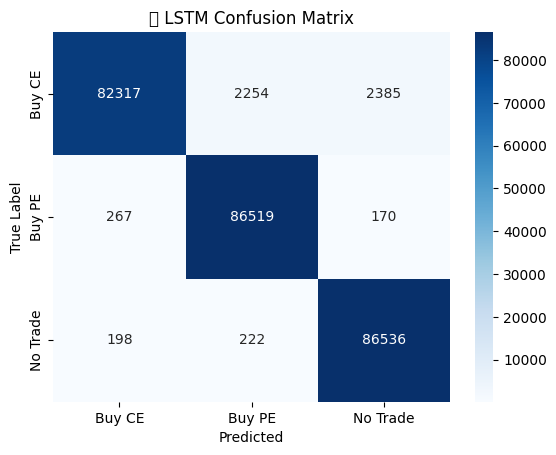

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_res, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Buy CE", "Buy PE", "No Trade"],
            yticklabels=["Buy CE", "Buy PE", "No Trade"])
plt.title("🔍 LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.show()


/Users/nil/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


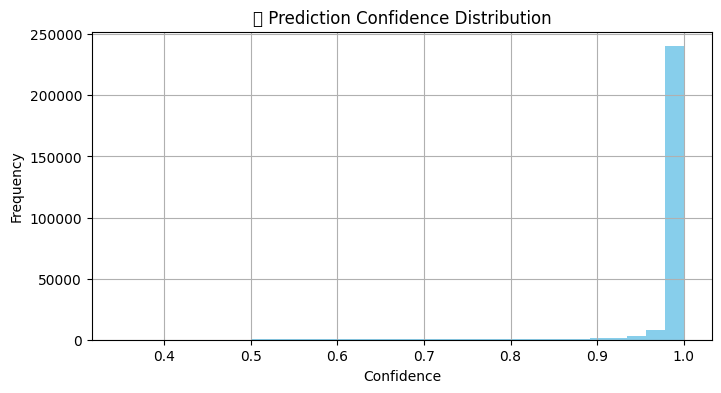

In [46]:
plt.figure(figsize=(8, 4))
plt.hist(confidences, bins=30, color='skyblue')
plt.title("📊 Prediction Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()
